## Absolute Position encoding

$$
\begin{align}
\text{PE}(pos, 2i) &= \sin(pos / 10000^{2i/d}) \\
\text{PE}(pos, 2i+1) &= \cos(pos / 10000^{2i/d})
\end{align}
$$


$$
\frac{1}{10000^{2i/d}} = 10000^{-2i/d} = e^{ln(10000^{-2i/d})} = e^{-\frac{2i}{d}ln(10000)}
$$



pe:
 tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.3171e-01,  ...,  1.0000e+00,
          1.0182e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.2355e-01,  ...,  1.0000e+00,
          2.0363e-04,  1.0000e+00],
        ...,
        [ 6.1950e-02,  9.9808e-01, -4.0069e-01,  ...,  9.9861e-01,
          5.1801e-02,  9.9866e-01],
        [ 8.7333e-01,  4.8714e-01, -9.8449e-01,  ...,  9.9860e-01,
          5.1902e-02,  9.9865e-01],
        [ 8.8177e-01, -4.7168e-01, -6.9253e-01,  ...,  9.9860e-01,
          5.2004e-02,  9.9865e-01]])


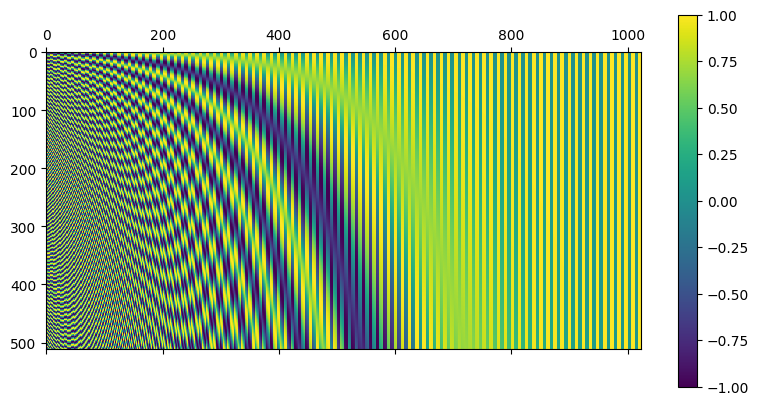

In [43]:
import torch
import math

max_len = 512
dim = 1024
pe = torch.zeros(max_len, dim)
position = torch.arange(0, max_len).unsqueeze(1).float()

div_term = torch.exp(-(torch.arange(0, dim, 2, dtype=torch.float) / dim * (math.log(10000.0))))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print("pe:\n", pe)

import matplotlib.pyplot as plt
cax = plt.matshow(pe)
plt.gcf().colorbar(cax)

## ROPE
In order to generalize our results in 2D to any $\boldsymbol{x}_i \in \mathbb{R}^d$ where $d$ is even,  we divide the d-dimension space into $d/2$ sub-spaces and combine them in the merit of the linearity of the inner product, turning $f_{\{q, k\}}$ into: 

$$
	f_{\{q, k\}}(\boldsymbol{x}_m, m) = \R^d_{\Theta, m}\boldsymbol{W}_{\{q, k\}}\boldsymbol{x}_m 
$$

$$   
	\R^d_{\Theta,m} = 
	\begin{pmatrix}
		\cos{m\theta_1}& -\sin{m\theta_1}&0&0&\cdots&0&0\\
		\sin{m\theta_1}&\cos{m\theta_1}&0&0&\cdots&0&0 \\
		0&0&\cos{m\theta_2}& -\sin{m\theta_2}&\cdots&0&0\\
		0&0&\sin{m\theta_2}&\cos{m\theta_2}&\cdots&0&0 \\
		\vdots&\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
		0&0&0&0&\cdots&\cos{m\theta_{d/2}}& -\sin{m\theta_{d/2}}\\
		0&0&0&0&\cdots&\sin{m\theta_{d/2}}&\cos{m\theta_{d/2}}
	\end{pmatrix}
$$

is the rotary matrix with pre-defined parameters $\Theta = \{\theta_i=10000^{-2(i-1)/d}, i \in [1, 2, ..., d/2]\}$. Applying our RoPE to self-attention, we obtain:

$$
	\boldsymbol{q}_m^{\intercal}\boldsymbol{k}_n 
	=(\boldsymbol{R}^d_{\Theta, m}\boldsymbol{W}_q\boldsymbol{x}_m)^\intercal(\boldsymbol{R}^d_{\Theta, n}\boldsymbol{W}_k\boldsymbol{x}_n) =\boldsymbol{x}^\intercal\boldsymbol{W}_qR^d_{\Theta, n-m}\boldsymbol{W}_k\boldsymbol{x}_n
$$

where $\R^d_{\Theta, n-m}=(\R^{d}_{\Theta, m})^\intercal\R^d_{\Theta, n}$.

$$
\begin{align} f_q\left( \bm{x}_m,m \right)  
&= 
\begin{pmatrix}  \cos m\theta & -\sin m\theta \\  \sin m \theta &  \cos m \theta  \\
\end{pmatrix} 
\begin{pmatrix}  q_m^{(1)}  \\  q_m^{(2)}    
\end{pmatrix} \\ &= \left( \cos m\theta *q_m^{(1)}-\sin m\theta *q_m^{(2)} ,\sin m\theta *q_m^{(1)}-\cos m\theta *q_m^{(2)} \right) \\
&=\left( \cos m\theta+i \sin m\theta \right)\cdot \left( q_m^{(1)}+i q_m^{(2)} \right)
\end{align}
$$

In [19]:
import torch
from torch import nn
from einx import rearrange
max_len = 1024
dim = 1024
batch_size = 8

theta = 10000.0 ** (-torch.arange(0, dim, 2)[: (dim // 2)].float() / dim)
m = torch.arange(max_len)
freqs = torch.outer(m, theta).float() ## [l, d(cos + sin)]
freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
"""
                      cos({0~l} * theta_{0, dim // 2}) + sin({0~l} * {0, dim // 2}) * j

cos(0 * theta_0) + sin(0 * theta_0) * j   cos(0 * theta_1) + sin(0 * theta_1) * j    cos(0 * theta_2) + sin(0 * theta_2) * j
cos(1 * theta_0) + sin(1 * theta_0) * j   cos(1 * theta_1) + sin(1 * theta_1) * j    cos(1 * theta_2) + sin(1 * theta_2) * j
"""
print(freqs_cis[100, 100]) ## freqs_cis[100, 100] = cos(100 * theta_100) + sin(100 * theta_100) * j
print("freqs_cis shape:", freqs_cis.shape)

## already projected by W_q and W_k
xq = torch.rand([batch_size, max_len, dim])
xk = torch.rand([batch_size, max_len, dim])
print("xq shape:", xq.shape)

xq_ = rearrange('b l (d two) -> b l d two', xq, two=2)
xk_ = rearrange('b l (d two) -> b l d two', xk, two=2)
print("xq_ shape:", xq_.shape)

xq_ = torch.view_as_complex(xq_)
xk_ = torch.view_as_complex(xk_)
print("xq_ as complex shape:", xq_.shape)
 
print("xq_ * freqs_cis shape:", (xq_ * freqs_cis).shape) ## [b l [d/2](0 + 1j)] * [l [d/2](cos + sin)]
xq_out = (torch.view_as_real(xq_ * freqs_cis)).flatten(2) 
xk_out = (torch.view_as_real(xk_ * freqs_cis)).flatten(2)
print("xq_out:", xq_out.shape)

tensor(-0.6673-0.7448j)
freqs_cis shape: torch.Size([1024, 512])
xq shape: torch.Size([8, 1024, 1024])
xq_ shape: torch.Size([8, 1024, 512, 2])
xq_ as complex shape: torch.Size([8, 1024, 512])
xq_ * freqs_cis shape: torch.Size([8, 1024, 512])
xq_out: torch.Size([8, 1024, 1024])


In [28]:
## llama code

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

    t = torch.arange(end, device=freqs.device, dtype=torch.float32)  # type: ignore
    freqs = torch.outer(t, freqs)  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]) 
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape) 


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    if not torch.cuda.is_available():
        xq = xq.to('cpu')
        xk = xk.to('cpu')
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

rope_theta = 10000
llama_freqs_cis = precompute_freqs_cis(dim, max_len, rope_theta)

xq = torch.rand([1, max_len, 8, dim]) ## [batch, length, n_head, dim] 
xk = torch.rand([1, max_len, 8, dim]) ## [batch, length, n_head, dim] 


emb = apply_rotary_emb(xq, xk, llama_freqs_cis)

## attention mask

In [26]:
import torch
Q = 8
K = 8
max_len = 32
attention = torch.rand([1, 1, Q, K])
mask = torch.ones(1, 1, max_len, max_len, dtype=torch.bool).tril(diagonal=0)
attention = attention.masked_fill(mask[:, :, :Q,:Q] == 0, float('-inf'))
print("mask_attention:\n", attention)
attention = torch.softmax(attention, dim=-1)
print("softmax_attention:\n", attention)

mask_attention:
 tensor([[[[0.3902,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
          [0.4225, 0.1181,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
          [0.7050, 0.0965, 0.8404,   -inf,   -inf,   -inf,   -inf,   -inf],
          [0.1381, 0.1485, 0.1623, 0.3332,   -inf,   -inf,   -inf,   -inf],
          [0.1218, 0.4098, 0.5131, 0.7131, 0.3326,   -inf,   -inf,   -inf],
          [0.6612, 0.4494, 0.9302, 0.6350, 0.5367, 0.6191,   -inf,   -inf],
          [0.5904, 0.4040, 0.6199, 0.9940, 0.5092, 0.5917, 0.3640,   -inf],
          [0.8878, 0.8599, 0.9144, 0.0362, 0.6412, 0.1253, 0.4594, 0.4681]]]])
softmax_attention:
 tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5755, 0.4245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3719, 0.2023, 0.4258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2353, 0.2377, 0.2410, 0.2860, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1459, 0.1946, 0.2158, 0.2636, 0.180